<a href="https://colab.research.google.com/github/shatakshisingh13/Data-Driven-Analysis-of-Seat-Belt-Usage/blob/main/Data_Driven_Analysis_of_Seat_Belt_Usage%2C_Legislation%2C_and_Road_Safety_Trends_in_the_United_States_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#imports
!pip install -q pandas numpy seaborn matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sqlite3

In [8]:
#load dataset and initial cleaning
DATA_URL = "https://raw.githubusercontent.com/salemprakash/EDA/main/Data/USSeatBelts.csv"
df = pd.read_csv(DATA_URL)

#remove unwanted index-like column if present
if 'rownames' in df.columns:
    df = df.drop(columns=['rownames'])

df.columns = df.columns.str.strip().str.lower()
print("Columns after cleaning:")
print(df.columns.tolist())
print("--------------------------------------------------\n")

print("Missing values (before cleaning):")
print(df.isna().sum())
print("--------------------------------------------------\n")

num_cols = ['miles','fatalities','seatbelt','speed65','speed70',
            'drinkage','alcohol','income','age']

for col in num_cols:
    if col in df.columns:
        df[col] = (df[col].astype(str)
                             .str.replace(',', '', regex=False)
                             .str.replace('%', '', regex=False)
                             .str.strip()
                             .replace({'no': np.nan, 'yes': 1, '': np.nan, 'Unknown': np.nan}))
        df[col] = pd.to_numeric(df[col], errors='coerce')

#fill numerical missing value with mean
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

#fill categorical missing value with Unknown
for col in ['state','enforce']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown').astype(str).str.strip()

print("Missing values (after cleaning):")
print(df.isna().sum())
print("--------------------------------------------------\n")

print("Cleaned dataset sample:")
display(df.head(10))


Columns after cleaning:
['state', 'year', 'miles', 'fatalities', 'seatbelt', 'speed65', 'speed70', 'drinkage', 'alcohol', 'income', 'age', 'enforce']
--------------------------------------------------

Missing values (before cleaning):
state           0
year            0
miles           0
fatalities      0
seatbelt      209
speed65         0
speed70         0
drinkage        0
alcohol         0
income          0
age             0
enforce         0
dtype: int64
--------------------------------------------------

Missing values (after cleaning):
state         0
year          0
miles         0
fatalities    0
seatbelt      0
speed65       0
speed70       0
drinkage      0
alcohol       0
income        0
age           0
enforce       0
dtype: int64
--------------------------------------------------

Cleaned dataset sample:


/tmp/ipython-input-2064903296.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'no': np.nan, 'yes': 1, '': np.nan, 'Unknown': np.nan}))
/tmp/ipython-input-2064903296.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'no': np.nan, 'yes': 1, '': np.nan, 'Unknown': np.nan}))
/tmp/ipython-input-2064903296.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to th

,state,year,miles,fatalities,seatbelt,speed65,speed70,drinkage,alcohol,income,age,enforce
0,AK,1983,3358,0.044669,0.528852,1.0,1.0,1.0,1.0,17973,28.234966,no
1,AK,1984,3589,0.037336,0.528852,1.0,1.0,1.0,1.0,18093,28.343542,no
2,AK,1985,3840,0.033073,0.528852,1.0,1.0,1.0,1.0,18925,28.372816,no
3,AK,1986,4008,0.025200,0.528852,1.0,1.0,1.0,1.0,18466,28.396652,no
4,AK,1987,3900,0.019487,0.528852,1.0,1.0,1.0,1.0,18021,28.453251,no
5,AK,1988,3841,0.025254,0.528852,1.0,1.0,1.0,1.0,18447,28.851419,no
6,AK,1989,3887,0.021610,0.528852,1.0,1.0,1.0,1.0,19970,29.148954,no
7,AK,1990,3979,0.024629,0.450000,1.0,1.0,1.0,1.0,21073,29.586285,no
8,AK,1991,4021,0.025118,0.660000,1.0,1.0,1.0,1.0,21496,29.827711,secondary
9,AK,1992,3841,0.028118,0.660000,1.0,1.0,1.0,1.0,22073,30.210697,secondary


In [9]:
#Feature Creation / Windowing / Ordering

#Sort dataset by year (and state if available)
if 'state' in df.columns:
    df = df.sort_values(['state', 'year'])
else:
    df = df.sort_values('year')

#Rolling window feature – 3-year moving average of fatalities
if 'fatalities' in df.columns:
    df['fatalities_roll3'] = (
        df.groupby('state')['fatalities']
          .rolling(window=3, min_periods=1)
          .mean()
          .reset_index(0, drop=True)
          if 'state' in df.columns
          else df['fatalities'].rolling(window=3, min_periods=1).mean()
    )

#Year-on-year percent change in fatalities
if 'fatalities' in df.columns:
    if 'state' in df.columns:
        df['fatalities_pct_change'] = (
            df.groupby('state')['fatalities'].pct_change().fillna(0)
        )
    else:
        df['fatalities_pct_change'] = df['fatalities'].pct_change().fillna(0)

#Create normalized miles (per 1,000) for scaling consistency
if 'miles' in df.columns:
    df['miles_per_1000'] = df['miles'] / 1000.0

#Final ordering and preview
df = df.reset_index(drop=True)
print("Feature creation complete — new columns added:")
print([c for c in df.columns if 'roll' in c or 'pct' in c or 'per_' in c])
print("--------------------------------------------------\n")

display(df.head(10))

Feature creation complete — new columns added:
['fatalities_roll3', 'fatalities_pct_change', 'miles_per_1000']
--------------------------------------------------



,state,year,miles,fatalities,seatbelt,speed65,speed70,drinkage,alcohol,income,age,enforce,fatalities_roll3,fatalities_pct_change,miles_per_1000
0,AK,1983,3358,0.044669,0.528852,1.0,1.0,1.0,1.0,17973,28.234966,no,0.044669,0.000000,3.358
1,AK,1984,3589,0.037336,0.528852,1.0,1.0,1.0,1.0,18093,28.343542,no,0.041003,-0.164165,3.589
2,AK,1985,3840,0.033073,0.528852,1.0,1.0,1.0,1.0,18925,28.372816,no,0.038360,-0.114189,3.840
3,AK,1986,4008,0.025200,0.528852,1.0,1.0,1.0,1.0,18466,28.396652,no,0.031870,-0.238059,4.008
4,AK,1987,3900,0.019487,0.528852,1.0,1.0,1.0,1.0,18021,28.453251,no,0.025920,-0.226687,3.900
5,AK,1988,3841,0.025254,0.528852,1.0,1.0,1.0,1.0,18447,28.851419,no,0.023314,0.295921,3.841
6,AK,1989,3887,0.021610,0.528852,1.0,1.0,1.0,1.0,19970,29.148954,no,0.022117,-0.144269,3.887
7,AK,1990,3979,0.024629,0.450000,1.0,1.0,1.0,1.0,21073,29.586285,no,0.023831,0.139692,3.979
8,AK,1991,4021,0.025118,0.660000,1.0,1.0,1.0,1.0,21496,29.827711,secondary,0.023786,0.019847,4.021
9,AK,1992,3841,0.028118,0.660000,1.0,1.0,1.0,1.0,22073,30.210697,secondary,0.025955,0.119418,3.841


In [10]:
#SQL-style Queries (using SQLite inside Colab)

import sqlite3

#Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')
df.to_sql('seatbelts', conn, index=False, if_exists='replace')

#Query: Yearly average seatbelt usage & total fatalities
query1 = """
SELECT year,
       ROUND(AVG(seatbelt), 3) AS avg_seatbelt,
       ROUND(SUM(fatalities), 3) AS total_fatalities
FROM seatbelts
GROUP BY year
ORDER BY year ASC;
"""
yearly_stats = pd.read_sql_query(query1, conn)

#Query: Top 10 states by average fatalities
query2 = """
SELECT state,
       ROUND(AVG(fatalities), 3) AS avg_fatalities,
       ROUND(AVG(seatbelt), 3) AS avg_seatbelt
FROM seatbelts
GROUP BY state
ORDER BY avg_fatalities DESC
LIMIT 10;
"""
state_summary = pd.read_sql_query(query2, conn)

print("SQL Query 1 – Yearly Averages:")
display(yearly_stats.head())

print("SQL Query 2 – Top 10 States by Fatalities:")
display(state_summary)


SQL Query 1 – Yearly Averages:


,year,avg_seatbelt,total_fatalities
0,1983,0.504,1.385
1,1984,0.469,1.348
2,1985,0.403,1.289
3,1986,0.423,1.306
4,1987,0.459,1.244


SQL Query 2 – Top 10 States by Fatalities:


,state,avg_fatalities,avg_seatbelt
0,MS,0.032,0.438
1,NM,0.031,0.649
2,SC,0.029,0.528
3,NV,0.029,0.543
4,AZ,0.029,0.583
5,AR,0.029,0.472
6,WV,0.028,0.517
7,TN,0.026,0.553
8,MT,0.026,0.553
9,LA,0.026,0.470


In [11]:
#Clustering (K-Means)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['fatalities', 'seatbelt', 'miles_per_1000', 'income', 'age']

df_cluster = df[features].dropna().copy()

#Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

#3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

print("Clustering complete. Cluster counts:")
print(df_cluster['cluster'].value_counts())

df.loc[df_cluster.index, 'cluster'] = df_cluster['cluster']
display(df_cluster.head(10))


Clustering complete. Cluster counts:
cluster
1    357
0    297
2    111
Name: count, dtype: int64


,fatalities,seatbelt,miles_per_1000,income,age,cluster
0,0.044669,0.528852,3.358,17973,28.234966,2
1,0.037336,0.528852,3.589,18093,28.343542,2
2,0.033073,0.528852,3.840,18925,28.372816,2
3,0.025200,0.528852,4.008,18466,28.396652,2
4,0.019487,0.528852,3.900,18021,28.453251,2
5,0.025254,0.528852,3.841,18447,28.851419,2
6,0.021610,0.528852,3.887,19970,29.148954,2
7,0.024629,0.450000,3.979,21073,29.586285,2
8,0.025118,0.660000,4.021,21496,29.827711,2
9,0.028118,0.660000,3.841,22073,30.210697,2


PCA complete.
Explained variance by PC1 and PC2: [0.464 0.197]


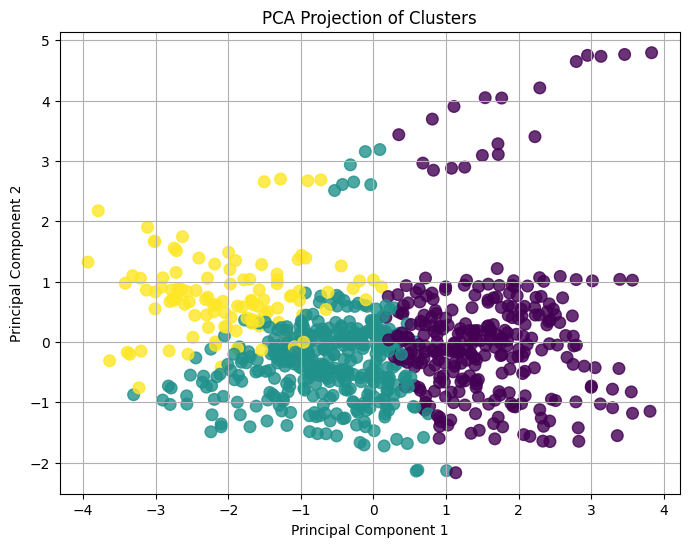

In [12]:
#Dimensionality Reduction (PCA)

from sklearn.decomposition import PCA

#Apply PCA to reduce dimensions to 2 components
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

#Add PCA components to dataframe
df_cluster['PC1'] = components[:, 0]
df_cluster['PC2'] = components[:, 1]

print("PCA complete.")
print(f"Explained variance by PC1 and PC2: {pca.explained_variance_ratio_.round(3)}")

#Scatter plot of clusters on PCA axes
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_cluster['PC1'], df_cluster['PC2'],
            c=df_cluster['cluster'], cmap='viridis', s=70, alpha=0.8)
plt.title('PCA Projection of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [14]:
#Comparison of Results (Before vs After PCA)

inertia_original = kmeans.inertia_

kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_pca.fit(components)
inertia_pca = kmeans_pca.inertia_

print("Comparison of Clustering Results:")
print(f"K-Means Inertia (original features): {inertia_original:.2f}")
print(f"K-Means Inertia (after PCA): {inertia_pca:.2f}")

#Interpretation comment
if inertia_pca < inertia_original:
    print("\nPCA slightly improved compactness — clusters are tighter and easier to visualize.")
else:
    print("\nPCA preserved the same clustering behavior — good dimensionality reduction consistency.")


Comparison of Clustering Results:
K-Means Inertia (original features): 2286.01
K-Means Inertia (after PCA): 1015.40

PCA slightly improved compactness — clusters are tighter and easier to visualize.


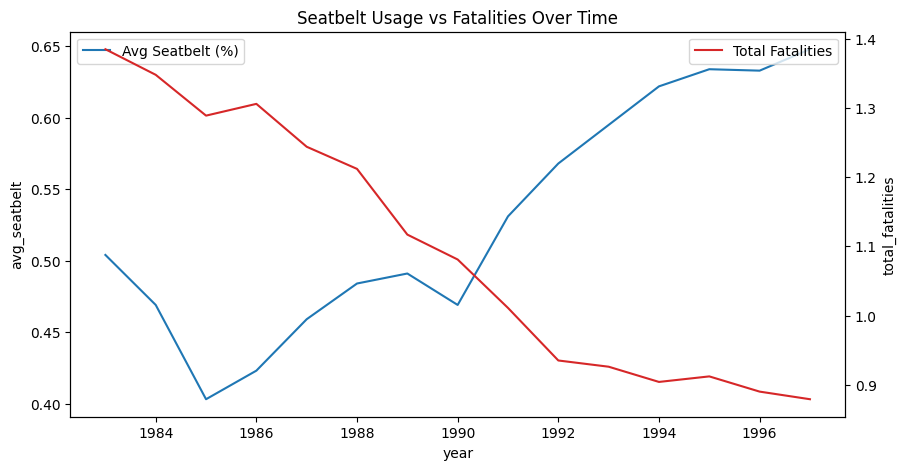

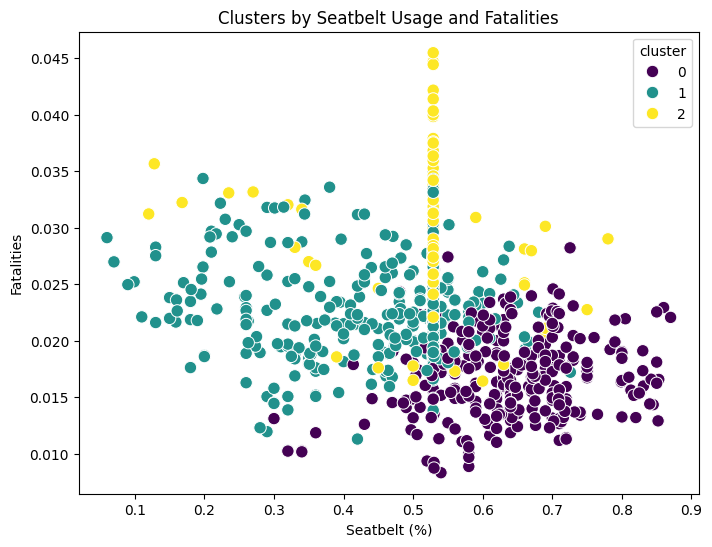

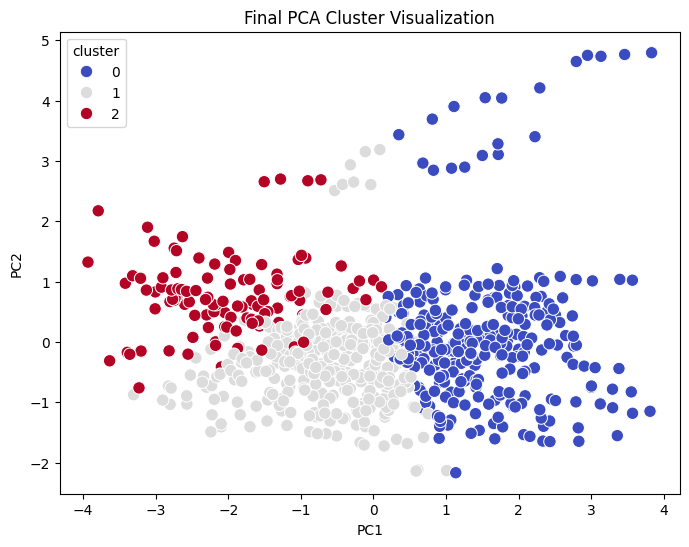

In [15]:
#Final Visualizations

import seaborn as sns
import matplotlib.pyplot as plt

#Yearly average seatbelt usage vs fatalities
plt.figure(figsize=(10,5))
sns.lineplot(data=yearly_stats, x='year', y='avg_seatbelt', label='Avg Seatbelt (%)', color='tab:blue')
ax2 = plt.twinx()
sns.lineplot(data=yearly_stats, x='year', y='total_fatalities', label='Total Fatalities', color='tab:red', ax=ax2)
plt.title('Seatbelt Usage vs Fatalities Over Time')
plt.show()

#Cluster visualization: seatbelt vs fatalities
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cluster, x='seatbelt', y='fatalities', hue='cluster', palette='viridis', s=80)
plt.title('Clusters by Seatbelt Usage and Fatalities')
plt.xlabel('Seatbelt (%)')
plt.ylabel('Fatalities')
plt.show()

# PCA component visualization with clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cluster, x='PC1', y='PC2', hue='cluster', palette='coolwarm', s=80)
plt.title('Final PCA Cluster Visualization')
plt.show()
